In [1]:
import os
import glob

import pandas as pd
import numpy as np
from pathlib import Path

import random
from tqdm.notebook import tqdm
import pydicom # Handle MRI images

import cv2  # OpenCV - https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

2021-10-11 10:53:30.852766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_dir = Path('../input/rsna-miccai-brain-tumor-radiogenomic-classification/')

mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_df = pd.read_csv(data_dir / "sample_submission.csv")
sample_submission = pd.read_csv(data_dir / "sample_submission.csv")

In [3]:
def load_dicom(path, size = 224):
    ''' 
    Reads a DICOM image, standardizes so that the pixel values are between 0 and 1, then rescales to 0 and 255
    
    Not super sure if this kind of scaling is appropriate, but everyone seems to do it. 
    '''
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    # transform data into black and white scale / grayscale
#     data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, (size, size))

def get_all_image_paths(brats21id, image_type, folder='train'): 
    '''
    Returns an arry of all the images of a particular type for a particular patient ID
    '''
    assert(image_type in mri_types)
    
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, 
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    return np.array(paths)

def get_all_images(brats21id, image_type, folder='train', size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(brats21id, image_type, folder)]

def get_all_data_for_train(image_type, image_size=32):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'train', image_size)
        label = x['MGMT_value']

        X.append(images)
        y.append(label)
        train_ids.append(int(x['BraTS21ID']))
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def resize_volume(img, desired_depth):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = desired_depth
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [4]:
X_train, y_train, trainidt = get_all_data_for_train('FLAIR', image_size=128)

  0%|          | 0/585 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
X_train =[np.array(np.moveaxis(im, 0, -1)) for im in X_train]  # Chnage shape from (depth, width, height) to (width, height, depth(fixed size))

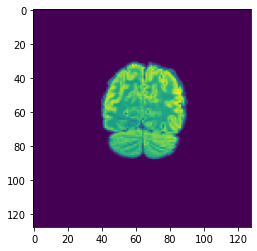

In [6]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0][:,:,100])

In [7]:
from scipy import ndimage

X_3d = []
for im in X_train:
    X_3d.append(resize_volume(im, 64))

In [8]:
X_3d[64].shape

(128, 128, 64)

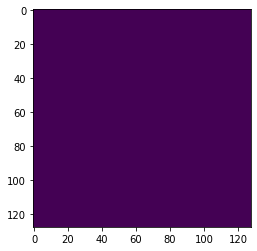

In [9]:
plt.imshow(X_3d[64][:,:,10])

In [10]:
# Saving in .npy so that we can use it directly for training and other stuffs 
with open('128_FLAIR_train_X_3D_64.npy', 'wb') as f:
    np.save(f, X_3d)
with open('128_FLAIR_train_y_3D_64.npy', 'wb') as f:
    np.save(f, y_train)
with open('128_FLAIR_train_id_3D_64.npy', 'wb') as f:
    np.save(f, trainidt)

In [11]:
len(X_3d), len(y_train), len(trainidt)

(585, 585, 585)